In [9]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable
import pandas as pd

from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad
from TO_sim.Get_2ndR_NORM import get_r_rp,Make_R_function

In [158]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [287]:
K = 10
m = 5
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,1000)
Xs = np.r_[Xs1,np.linspace(1e-3,20,1001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd

Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


In [98]:
Xs1 = np.logspace(-15,-3,1000)
Xs = np.r_[Xs1,np.linspace(1e-3,20,1001)]

R_ls = []
R_drs = []


for X in Xs:
    omega_p = X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R10 = np.array(R_ls)
R1D = 2*np.array(R_drs)
R1 = R10 -R1D
KK1 = 1/(R1/Xs)
K_min_arg = np.argmin(KK)

K_d1 = KK1[:K_min_arg]
K_u1 = KK1[K_min_arg:]
r_d1 = Xs[:K_min_arg]/K_d1
r_u1 = Xs[K_min_arg:]/K_u1
R_01d = R10[:K_min_arg]
R_01u = R10[K_min_arg:]
R_d1d = -R1D[:K_min_arg]
R_d1u = -R1D[K_min_arg:]

R_u1 = R_01u + R_d1u
R_d1 = R_01d + R_d1d

Xsu1 = Xs[K_min_arg:]
Xsd1 = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS1 = Xsu


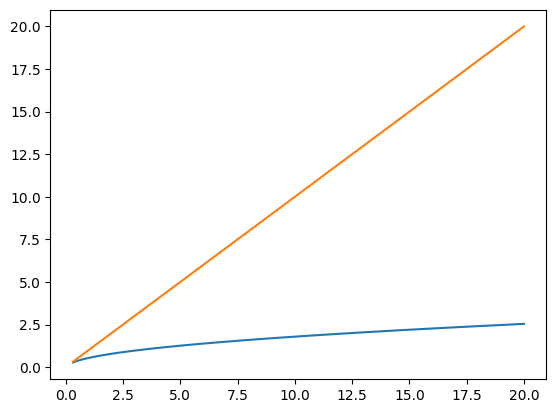

In [85]:
plt.plot(Xsu,OPS)
plt.plot(Xsu,OPS1)

Text(0, 0.5, '$F(X)=r$')

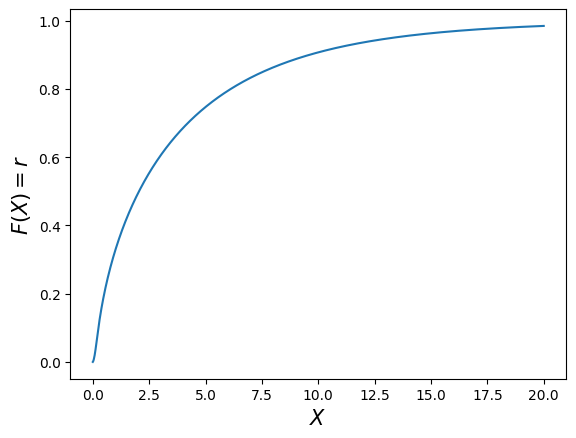

In [17]:
plt.plot(Xs,R0-RD)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)

Text(0, 0.5, '$G(X)=K$')

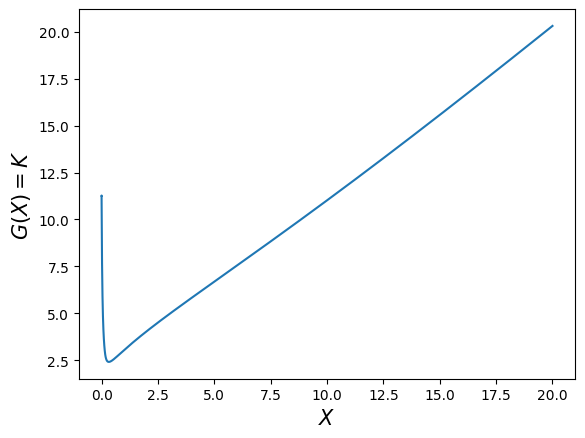

In [18]:
plt.plot(Xs,KK)
plt.xlabel(r'$X$',fontsize=15)
plt.ylabel(r'$G(X)=K$',fontsize=15)

Text(0, 0.5, '$F(X)=r$')

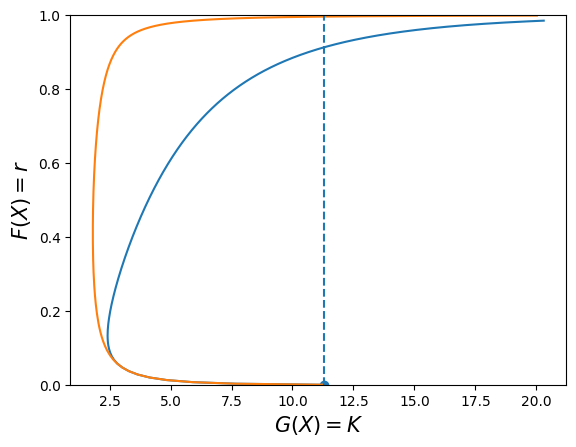

In [86]:
plt.plot(KK,Xs/KK)
plt.plot(KK1,R1)
plt.scatter(KK[0],Xs[0]/KK[0])
plt.axvline(KK[0],ls='--')
plt.ylim(0,1)
plt.xlabel(r'$G(X)=K$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)

In [ ]:
# RP_u = []
# RP_d = []

# RP0_u = []
# RP0_d = []
# Kp = []

# def get_rp(X,K,r0,OP):
#     rs1 = np.logspace(-6,-2,100)
#     rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
#     RP_ls = np.nan*rps
#     RP_ds = np.nan*rps

#     for i,rp in enumerate(rps):
#         a = 1/np.sqrt(K*rp*m)
#         b = 4/np.pi * a - 0.3056*a**3
#         b = np.where(np.where(a>1.193,1,b)>=1,1,b)
#         OPs = b*K*rp

#         delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
#         RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(K*rp,OP,delta_P,m),limit=200)
#         RP_ds[i],err = quad(integrand_Rd2, OPs,np.inf,args=(K*rp,OP,delta_P,m),limit=200)
#     RP = (RP_ls-RP_ds)
#     x, = np.where((RP-rps)>=0)
#     try:
#         rp_d = rps[x[0]]
#         rp_u = rps[x[-1]]
#         rp0_d = RP_ls[x[0]]
#         rp0_u = RP_ls[x[-1]]
#         return K,rp_d,rp_u,rp0_d,rp0_u
#     except:
#         return K,np.nan,np.nan,np.nan,np.nan
    
# get_rp = np.vectorize(get_rp)





# def get_rp1(X,K,r0,OP):
#     rs1 = np.logspace(-6,-2,100)
#     rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
#     RP_ls = np.nan*rps
#     RP_ds = np.nan*rps

#     for i,rp in enumerate(rps):
#         OPs = K*rp

#         delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
#         RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(K*rp,OP,delta_P,m),limit=200)
#         RP_ds[i],err = quad(integrand_Rd2, OPs,np.inf,args=(K*rp,OP,delta_P,m),limit=200)
#     RP_ds *= K*rps 
#     RP = (RP_ls-RP_ds)
#     x, = np.where((RP-rps)>=0)
#     try:
#         rp_d = rps[x[0]]
#         rp_u = rps[x[-1]]
#         rp0_d = RP_ls[x[0]]
#         rp0_u = RP_ls[x[-1]]
#         return K,rp_d,rp_u,rp0_d,rp0_u
#     except:
#         return K,np.nan,np.nan,np.nan,np.nan
    
# get_rp1 = np.vectorize(get_rp1)

In [250]:


def get_rp(X,K,r0,OP,MAX=False):
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,300)] 
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        if MAX:
            OPs = K*rp
        else:
            OPs = b*K*rp
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)


    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    try:
        rp_d = rps[x[0]]
        rp_u = rps[x[-1]]
        rp0_d = RP_ls[x[0]]
        rp0_u = RP_ls[x[-1]]
        return K,rp_d,rp_u,rp0_d,rp0_u
    except:
        return K,np.nan,np.nan,np.nan,np.nan
    
get_rp = np.vectorize(get_rp)


In [303]:
Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(Xsu,K_u,R_0u,OPS,MAX=False)
# K1,rp_d1,rp_u1,rp0_d1,rp0_u1 = get_rp1(Xsu,K_u,R_0u,OPS)

In [304]:
KsM,rpM_d,rpM_u,rpM0_d,rpM0_u = get_rp(Xsu,K_u,R_0u,OPS,MAX=True)


In [322]:
Ks[~np.isnan(rp_d)]

array([ 2.6630896 ,  2.6841593 ,  2.7053752 ,  2.72670714,  2.74812941,
        2.76962005,  2.79116027,  2.81273398,  2.83432736,  2.85592854,
        2.87752732,  2.89911496,  2.92068391,  2.94222772,  2.96374085,
        2.98521856,  3.00665681,  3.02805214,  3.04940166,  3.07070289,
        3.0919538 ,  3.11315267,  3.13429812,  3.15538902,  3.17642448,
        3.19740383,  3.21832656,  3.23919234,  3.26000098,  3.28075239,
        3.30144662,  3.32208379,  3.34266412,  3.36318788,  3.38365543,
        3.40406717,  3.42442355,  3.44472506,  3.46497222,  3.4851656 ,
        3.50530577,  3.52539333,  3.54542892,  3.56541317,  3.58534673,
        3.60523026,  3.62506442,  3.64484989,  3.66458735,  3.68427748,
        3.70392094,  3.72351844,  3.74307063,  3.7625782 ,  3.78204182,
        3.80146216,  3.82083988,  3.84017564,  3.8594701 ,  3.87872389,
        3.89793766,  3.91711205,  3.93624768,  3.95534516,  3.97440511,
        3.99342814,  4.01241483,  4.03136578,  4.05028157,  4.06

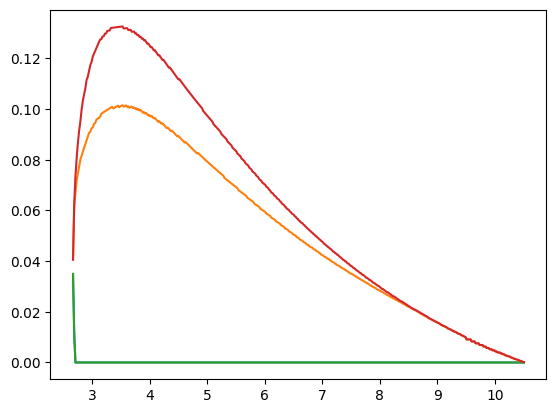

In [320]:
plt.plot(Ks,rp_d)
plt.plot(Ks,rp_u)

plt.plot(KsM,rpM_d)
plt.plot(KsM,rpM_u)


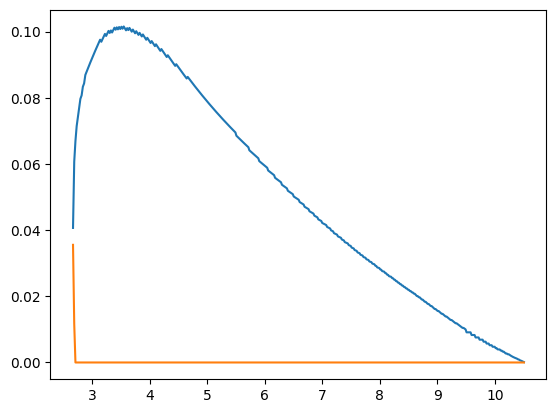

In [172]:
plt.plot(K2,rp_u2)
plt.plot(K2,rp_d2)

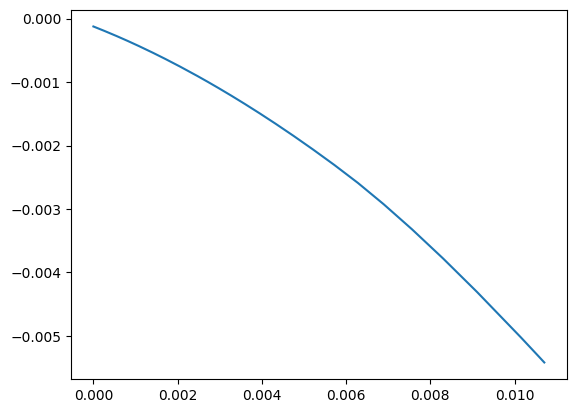

In [421]:
plt.plot(rps,RP-rps)

In [601]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        OPs = K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(X,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd2, OPs,np.inf,args=(X,OP,delta_P,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:pass

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_33840/4186010132.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_ls[i],err = quad(integrand_Rl2, -delta_P,+OPs,args=(X,OP,delta_P,m),limit=200)


In [173]:
R_du

array([-0.05328899, -0.05410476, -0.05486   , -0.05556049, -0.05621121,
       -0.05681645, -0.05737999, -0.05790512, -0.05839477, -0.05885156,
       -0.0592778 , -0.05967558, -0.06004681, -0.06039318, -0.06071626,
       -0.06101746, -0.06129807, -0.06155929, -0.06180221, -0.06202783,
       -0.06223711, -0.06243088, -0.06260997, -0.06277511, -0.062927  ,
       -0.06306629, -0.06319358, -0.06330944, -0.0634144 , -0.06350897,
       -0.06359361, -0.06366877, -0.06373486, -0.06379227, -0.06384139,
       -0.06388255, -0.06391609, -0.06394233, -0.06396156, -0.06397407,
       -0.06398014, -0.06398   , -0.06397392, -0.06396212, -0.06394482,
       -0.06392224, -0.06389457, -0.06386201, -0.06382474, -0.06378294,
       -0.06373677, -0.06368641, -0.06363199, -0.06357367, -0.0635116 ,
       -0.0634459 , -0.06337671, -0.06330415, -0.06322834, -0.0631494 ,
       -0.06306744, -0.06298257, -0.06289489, -0.0628045 , -0.06271149,
       -0.06261596, -0.062518  , -0.06241768, -0.0623151 , -0.06

In [288]:
RPS = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    omega_pp = X
    rp = -rd/2
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = b*K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    RPS.append(RP)
    # x, = np.where((RP-rps)>=0)
    # try:
    #     RP1_u.append(rps[x[-1]])
    #     RP1_d.append(rps[x[0]])
    #     RP01_u.append(RP_ls[x[-1]])
    #     RP01_d.append(RP_ls[x[0]])
    #     K1p.append(K)
    # except:pass

In [289]:
RPSd = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsd,K_d,R_d,R_0d,R_dd,OPSd):
    omega_pp = X
    rp = -rd/2
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = b*K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    RPSd.append(RP)

Text(0.5, 1.0, '$m=5$')

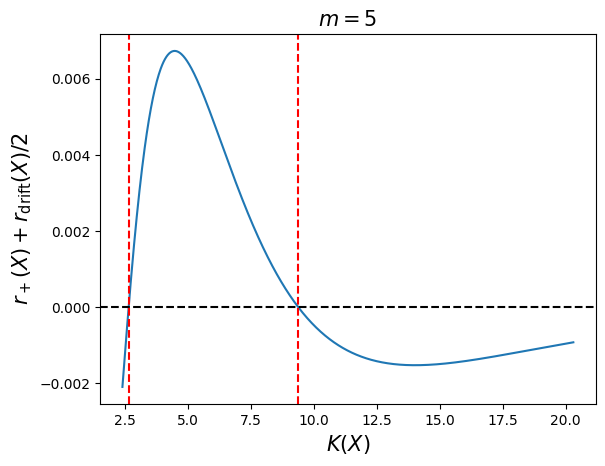

In [293]:
x, = np.where(RPS+R_du/2>=0)
plt.plot(K_u,RPS+R_du/2)
plt.axhline(0,ls='--',color='black')
plt.xlabel(r'$K(X)$',fontsize=15)
plt.ylabel(r'$r_+(X)+r_{\rm{drift}}(X)/2$',fontsize=15)

plt.axvline(K_u[x[0]],color='red',ls='--')
plt.axvline(K_u[x[-1]],color='red',ls='--')
plt.title(rf'$m={m}$',fontsize=15)
# plt.plot(K_d,RPSd+R_dd/2)

In [323]:
print(K_u[x[-1]])

9.387043567333603


Text(0.5, 1.0, '$m=3.9$')

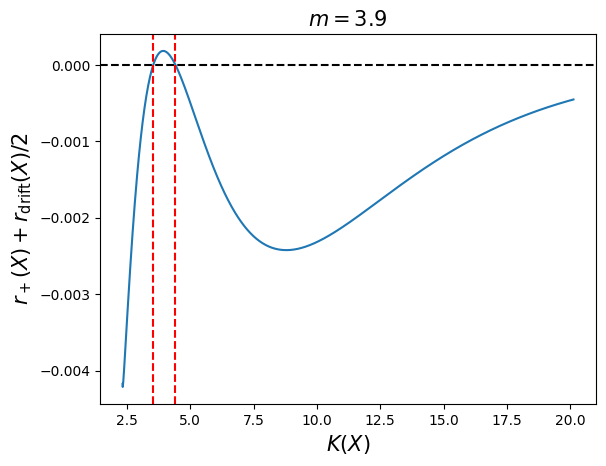

In [281]:
x, = np.where(RPS+R_du/2>=0)
plt.plot(K_u,RPS+R_du/2)
plt.axhline(0,ls='--',color='black')
plt.xlabel(r'$K(X)$',fontsize=15)
plt.ylabel(r'$r_+(X)+r_{\rm{drift}}(X)/2$',fontsize=15)

plt.axvline(K_u[x[0]],color='red',ls='--')
plt.axvline(K_u[x[-1]],color='red',ls='--')
plt.title(rf'$m={m}$',fontsize=15)

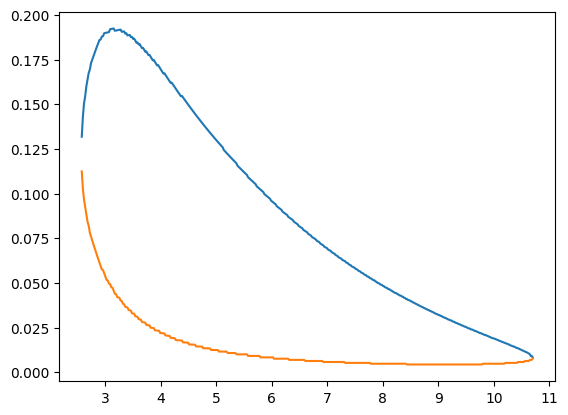

In [602]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

In [386]:
np.max(np.diff(K_u)),np.max(Kp),np.max(K1p)

(0.019512806275034933, 7.069041117236938, 7.069041117236938)

In [53]:
F_rN = get_r_rp(m,0,K_max=15,K_len=401)

/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:157: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
/Users/kimgug-young/Desktop/KURAMOTO 1st order/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:158: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in F_sec (vectorized)
  outputs = ufunc(*inputs)


In [42]:
df = pd.read_excel('N = 5000 seed = 10 QNORMAL w pv.xlsm')
Ks_ = np.arange(0,10.05,0.1)

In [305]:
m

5

In [306]:
df[df.m==m]

,K,m,S0,S+,S-,rm,r0,r+,r-,r+_total,r-_total,sig,sig+_total,sig-_total,v0,v+,v-
50,NaN,5.0,NaN,NaN,NaN,0.013262,NaN,NaN,NaN,0.009816,0.007825,0.007512,0.005149,0.003744,NaN,NaN,NaN
151,NaN,5.0,NaN,NaN,NaN,0.012492,NaN,NaN,NaN,0.009195,0.007322,0.007034,0.004900,0.003590,NaN,NaN,NaN
252,NaN,5.0,NaN,NaN,NaN,0.011801,NaN,NaN,NaN,0.008684,0.006922,0.006617,0.004702,0.003432,NaN,NaN,NaN
353,NaN,5.0,NaN,NaN,NaN,0.011189,NaN,NaN,NaN,0.008264,0.006601,0.006267,0.004530,0.003286,NaN,NaN,NaN
454,NaN,5.0,NaN,NaN,NaN,0.010647,NaN,NaN,NaN,0.007918,0.006335,0.005981,0.004369,0.003163,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9746,NaN,5.0,4527.0,NaN,NaN,0.877010,0.901325,NaN,NaN,0.015157,0.015058,0.014061,0.005183,0.005468,-0.000316,NaN,NaN
9847,NaN,5.0,4534.0,NaN,NaN,0.879285,0.902739,NaN,NaN,0.014555,0.014464,0.014352,0.005389,0.005496,-0.000027,NaN,NaN
9948,NaN,5.0,4549.0,NaN,NaN,0.882633,0.905855,NaN,NaN,0.011819,0.011699,0.003183,0.001891,0.001867,-0.000253,NaN,NaN
10049,NaN,5.0,4560.0,NaN,NaN,0.885470,0.908117,NaN,NaN,0.011726,0.011324,0.002375,0.001979,0.001819,-0.001031,NaN,NaN


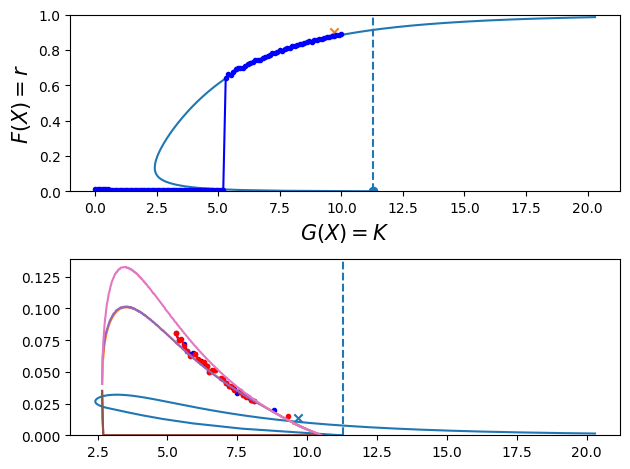

In [418]:
plt.subplot(211)
plt.plot(KK,Xs/KK)
plt.plot(Ks_,df[df.m==m]['rm'],'.-',color='blue')
# plt.plot(Ks,df[df.m==m]['R'],'.-',color='red')

plt.scatter(KK[0],Xs[0]/KK[0])
plt.axvline(KK[0],ls='--')
# plt.plot(K1K,Xs/K1K)
plt.ylim(0,1)
plt.xlabel(r'$G(X)=K$',fontsize=15)
plt.ylabel(r'$F(X)=r$',fontsize=15)
plt.scatter(K,r0_,marker='x')

plt.subplot(212)
plt.axvline(KK[0],ls='--')

plt.plot(KK,RD/2)
plt.plot(F_rN['Ks'],F_rN['r_+u'])
plt.plot(F_rN['Ks'],F_rN['r_+d'])



# plt.plot(Kp,RP0_u)
# plt.plot(Kp,RP0_d)
plt.plot(Ks_,df[df.m==m]['r+'],'.-',color='blue')
plt.plot(Ks_,df[df.m==m]['r-'],'.-',color='red')

plt.plot(Ks,rp_d)
plt.plot(Ks,rp_u)

plt.plot(KsM,rpM_d)
plt.plot(KsM,rpM_u)

# plt.plot(K1p,RP01_u)
# plt.plot(K1p,RP01_d)
plt.scatter(K,rp,marker='x')
plt.ylim(0,)
plt.tight_layout()



In [567]:
K[~np.isnan(rp_u)]

array([ 2.83432736,  2.85592854,  2.87752732,  2.89911496,  2.92068391,
        2.94222772,  2.96374085,  2.98521856,  3.00665681,  3.02805214,
        3.04940166,  3.07070289,  3.0919538 ,  3.11315267,  3.13429812,
        3.15538902,  3.17642448,  3.19740383,  3.21832656,  3.23919234,
        3.26000098,  3.28075239,  3.30144662,  3.32208379,  3.34266412,
        3.36318788,  3.38365543,  3.40406717,  3.42442355,  3.44472506,
        3.46497222,  3.4851656 ,  3.50530577,  3.52539333,  3.54542892,
        3.56541317,  3.58534673,  3.60523026,  3.62506442,  3.64484989,
        3.66458735,  3.68427748,  3.70392094,  3.72351844,  3.74307063,
        3.7625782 ,  3.78204182,  3.80146216,  3.82083988,  3.84017564,
        3.8594701 ,  3.87872389,  3.89793766,  3.91711205,  3.93624768,
        3.95534516,  3.97440511,  3.99342814,  4.01241483,  4.03136578,
        4.05028157,  4.06916277,  4.08800994,  4.10682364,  4.12560442,
        4.14435281,  4.16306936,  4.18175457,  4.20040898,  4.21

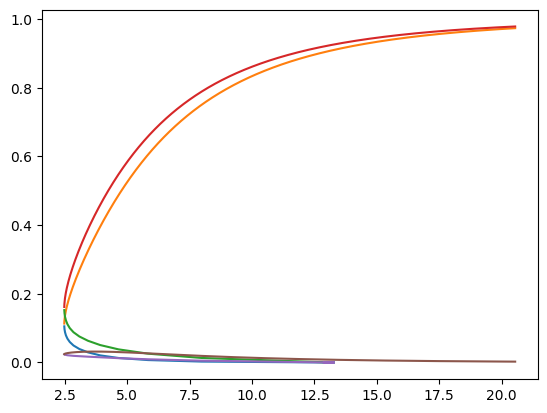

In [272]:
plt.plot(K_d,r_d)
plt.plot(K_u,r_u)
plt.plot(K_d,R_0d)
plt.plot(K_u,R_0u)


plt.plot(K_d,-R_dd/2)
plt.plot(K_u,-R_du/2)

In [273]:
plt.plot(Xs,RL -RD)
# plt.ylim(-0.001,0.01)
# plt.xscale('log')
# plt.plot(rs,rs)

ValueError: operands could not be broadcast together with shapes (11000,) (2001,) 

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2


from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian

from TO_sim.get_cluster import cluster_os_new2

In [28]:
avg_dthetas = {}
r_c = {}

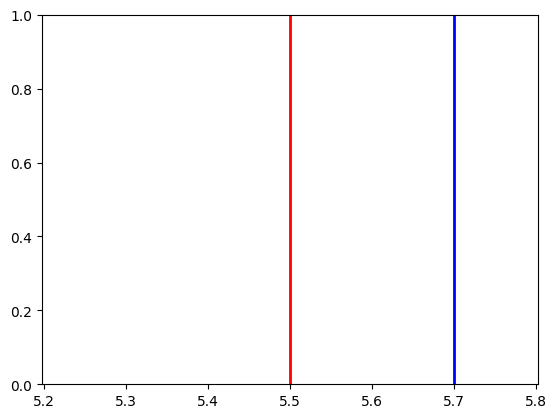

In [29]:

plt.axvline(5.5,lw=2,color='red')
plt.axvline(5.7,lw=2,color='blue')

In [404]:
seed =11
N = 5000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
dt = 0.1
t = np.arange(0,5000,dt)
# K = 5.3
K = 9.387 + 0.3
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [405]:
del dtheta

In [406]:
avg_dtheta = (theta[-50:] - theta[-1051:-1001])/(100)

In [407]:
CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-2:],height=0.01,check=2,c_size=1,omega=omega)

CS

array([4534])

In [413]:
cluster.astype(int)

array([[ 233,  234,  235, ..., 4699, 4700, 4766]])

In [415]:
r0_ = np.mean(np.abs(np.sum(np.exp(1j*theta[-500:,cluster[0].astype(int)]),axis=1))/N)


In [ ]:
rp = np.mean(np.abs(np.sum(np.exp(1j*theta[-500:,cluster[1]]),axis=1))/N)

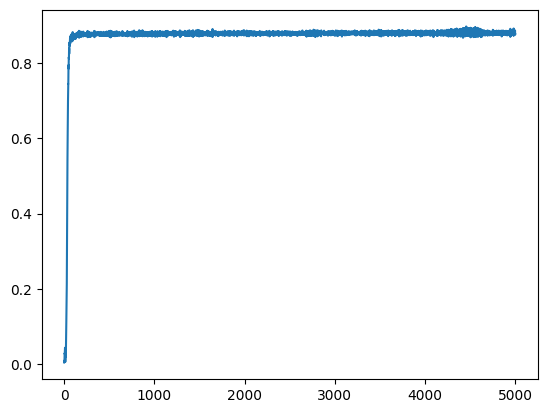

In [416]:
plt.plot(t,rs)

IndexError: index 1 is out of bounds for axis 0 with size 1

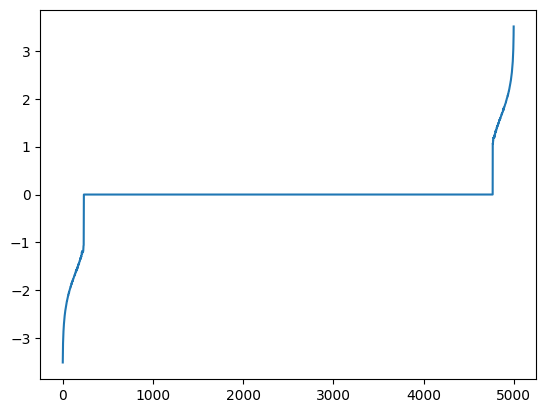

In [417]:
plt.plot(avg_dtheta[-1])
plt.scatter(cluster[1],avg_dtheta[-1,cluster[1]])